<a href="https://colab.research.google.com/github/recognita/EIM-for-Muscle-Construction-Detection/blob/main/challenge1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🌐 **Google Drive Connection**

In [6]:
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/AN2DL/challenge1"
%cd $current_dir

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/AN2DL/challenge1


#Fusilli model

In [6]:
import pandas as pd
# 1) Загружаем данные
df = pd.read_csv("pirate_pain_train.csv")

# Таблица с лейблами, например: sample_index, label
labels = pd.read_csv("pirate_pain_train_labels.csv")
# fusilli хочет колонку 'prediction_label'
labels = labels.rename(columns={"label": "prediction_label"})

In [7]:
# Убедимся, что у каждого sample_index одинаковое кол-во тайм-степов
counts = df.groupby("sample_index")["time"].nunique()
if counts.nunique() != 1:
    raise ValueError("Разное число временных точек для разных sample_index!")
T = counts.iloc[0]  # число временных шагов
print("Число временных точек на семпл:", T)

Число временных точек на семпл: 160


In [8]:
def flatten_over_time(group, feature_cols, T):
    """
    group: подтаблица для одного sample_index
    feature_cols: какие фичи разворачиваем
    T: число временных шагов
    """
    # сортируем по времени, чтобы порядок был одинаковый
    g = group.sort_values("time")

    # берём только нужные столбцы, получаем (T, num_features)
    arr = g[feature_cols].to_numpy()
    if arr.shape[0] != T:
        raise ValueError(f"Ожидалось {T} тайм-степов, а есть {arr.shape[0]}")

    # разворачиваем в вектор длины T * num_features
    flat = arr.reshape(-1)

    # генерируем имена колонок вида: col_1, col_2, ...
    colnames = []
    for t in range(1, T + 1):
        for c in feature_cols:
            colnames.append(f"{c}_{t}")

    return pd.Series(flat, index=colnames)

In [ ]:
# Все колонки, которые начинаются с 'joint_'
exclude = (
    "joint_13", "joint_14", "joint_15", "joint_16",
    "joint_18", "joint_19", "joint_20", "joint_21",
    "joint_22", "joint_23", "joint_24", "joint_25", "joint_30"
)

joint_cols = [
    c for c in df.columns
    if c.startswith("joint_") and c not in exclude
]

tab1_wide = (
    df.groupby("sample_index")
      .apply(flatten_over_time, feature_cols=joint_cols, T=T)
      .reset_index()  # вернём sample_index как колонку
)

# Добавляем лейблы, переименовываем в формат fusilli
tab1 = tab1_wide.merge(labels, on="sample_index")
tab1 = tab1.rename(columns={"sample_index": "ID"})

# На этом шаге tab1: ID, joint_00_1, joint_01_1, ..., prediction_label
tab1.to_csv("tabular_1.csv", index=False)

In [10]:
# Если n_legs хранится как строка "two"
df["disability"] = (df["n_legs"] != "two").astype(int)

# Если вдруг оно числовое, типа 2:
# df["disability"] = (df["n_legs"] != 2).astype(int)

pain_cols = ["pain_survey_1", "pain_survey_2", "pain_survey_3", "disability"]
# Если хочешь ещё pain_survey_4, просто добавь в список:
# pain_cols = ["pain_survey_1", "pain_survey_2", "pain_survey_3", "pain_survey_4", "disability"]

tab2_wide = (
    df.groupby("sample_index")
      .apply(flatten_over_time, feature_cols=pain_cols, T=T)
      .reset_index()
)

tab2 = tab2_wide.merge(labels, on="sample_index")
tab2 = tab2.rename(columns={"sample_index": "ID"})

# tab2: ID, pain_survey_1_1, pain_survey_2_1, ..., disability_T, prediction_label
tab2.to_csv("tabular_2.csv", index=False)

In [ ]:
!pip install "numpy<2.0.0" --force-reinstall

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.2

In [5]:
import os, glob
print("CWD:", os.getcwd())

print("CSV рядом:", glob.glob("*.csv"))

CWD: /content
CSV рядом: []


In [14]:
import pandas as pd
# 1) Берём исходные текстовые лейблы
labels = pd.read_csv("pirate_pain_train_labels.csv")
unique_labels = sorted(labels["label"].unique())
label_to_id = {lab: i for i, lab in enumerate(unique_labels)}

# 2) Патчим tabular_1.csv
tab1 = pd.read_csv("tabular_1.csv")
tab1["prediction_label"] = tab1["prediction_label"].map(label_to_id).astype("int64")
tab1.to_csv("tabular_1.csv", index=False)

# 3) Патчим tabular_2.csv
tab2 = pd.read_csv("tabular_2.csv")
tab2["prediction_label"] = tab2["prediction_label"].map(label_to_id).astype("int64")
tab2.to_csv("tabular_2.csv", index=False)

In [15]:
!pip install fusilli

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 49.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: num

Imported methods:
['Tabular1 uni-modal' 'Tabular2 uni-modal'
 'Concatenating tabular feature maps' 'Concatenating tabular data'
 'Channel-wise multiplication net (tabular)'
 'Tabular Crossmodal multi-head attention' 'Tabular decision'
 'MCVAE Tabular' 'Edge Correlation GNN' 'Attention-weighted GNN'
 'Activation function and tabular self-attention'
 'Activation function map fusion']


INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO: 
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | Tabular1Unimodal | 283 K  | train
---------------------------------------------------
283 K     Trainable params
0         Non-trainable params
283 K     Total params
1.135     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | Tabular1Unimodal | 283 K

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         AUROC_val         │    0.8989710807800293     │
│       Accuracy_val        │    0.7878788113594055     │
│         val_loss          │    0.4221363067626953     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /gdrive/MyDrive/AN2DL/challenge1/path/to/checkpoints/dir exists and is not empty.
INFO: 
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | Tabular2Unimodal | 212 K  | train
---------------------------------------------------
212 K     Trainable params
0         Non-trainable params
212 K     Total params
0.849     Total estimated model params size (MB)
26        Modules in train mode
0         Modules

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         AUROC_val         │    0.5428082346916199     │
│       Accuracy_val        │    0.7196969985961914     │
│         val_loss          │    1.5804449319839478     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /gdrive/MyDrive/AN2DL/challenge1/path/to/checkpoints/dir exists and is not empty.
INFO: 
  | Name  | Type                     | Params | Mode 
-----------------------------------------------------------
0 | model | ConcatTabularFeatureMaps | 479 K  | train
-----------------------------------------------------------
479 K     Trainable params
0         Non-trainable params
479 K     Total params
1.917     Total estimated model params size (MB)
42        Modules

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         AUROC_val         │    0.5675438046455383     │
│       Accuracy_val        │    0.7424242496490479     │
│         val_loss          │    1.5285720825195312     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /gdrive/MyDrive/AN2DL/challenge1/path/to/checkpoints/dir exists and is not empty.
INFO: 
  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | ConcatTabularData | 918 K  | train
----------------------------------------------------
918 K     Trainable params
0         Non-trainable params
918 K     Total params
3.672     Total estimated model params size (MB)
10        Modules in train mode
0         Mod

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         AUROC_val         │    0.9014017581939697     │
│       Accuracy_val        │    0.8257575631141663     │
│         val_loss          │    0.43495169281959534    │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /gdrive/MyDrive/AN2DL/challenge1/path/to/checkpoints/dir exists and is not empty.
INFO: 
  | Name  | Type                             | Params | Mode 
-------------------------------------------------------------------
0 | model | TabularChannelWiseMultiAttention | 413 K  | train
-------------------------------------------------------------------
413 K     Trainable params
0         Non-trainable params
413 K     Total params
1.655     Total estimated model pa

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         AUROC_val         │    0.6140958666801453     │
│       Accuracy_val        │    0.7651515007019043     │
│         val_loss          │    0.6888553500175476     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /gdrive/MyDrive/AN2DL/challenge1/path/to/checkpoints/dir exists and is not empty.
INFO: 
  | Name  | Type                                | Params | Mode 
----------------------------------------------------------------------
0 | model | TabularCrossmodalMultiheadAttention | 367 K  | train
----------------------------------------------------------------------
367 K     Trainable params
0         Non-trainable params
367 K     Total params
1.471     Total estima

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         AUROC_val         │    0.5238106846809387     │
│       Accuracy_val        │            0.5            │
│         val_loss          │    1.6310348510742188     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /gdrive/MyDrive/AN2DL/challenge1/path/to/checkpoints/dir exists and is not empty.
INFO: 
  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | TabularDecision | 332 K  | train
--------------------------------------------------
332 K     Trainable params
0         Non-trainable params
332 K     Total params
1.331     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in 

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         AUROC_val         │     0.644749641418457     │
│       Accuracy_val        │    0.7348484992980957     │
│         val_loss          │    1.2225074768066406     │
└───────────────────────────┴───────────────────────────┘

RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cuda:0, different from other tensors on cpu (when checking argument in method wrapper_CUDA_addmm)

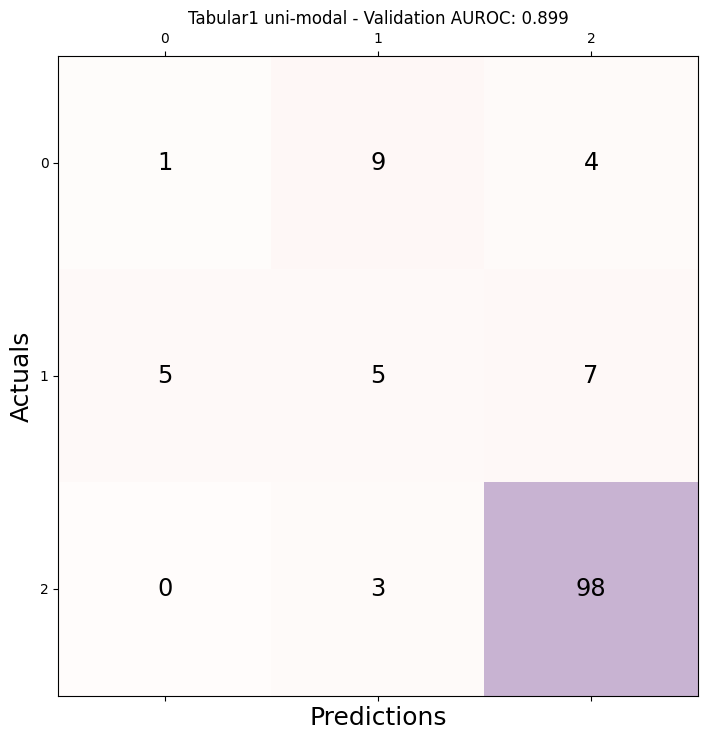

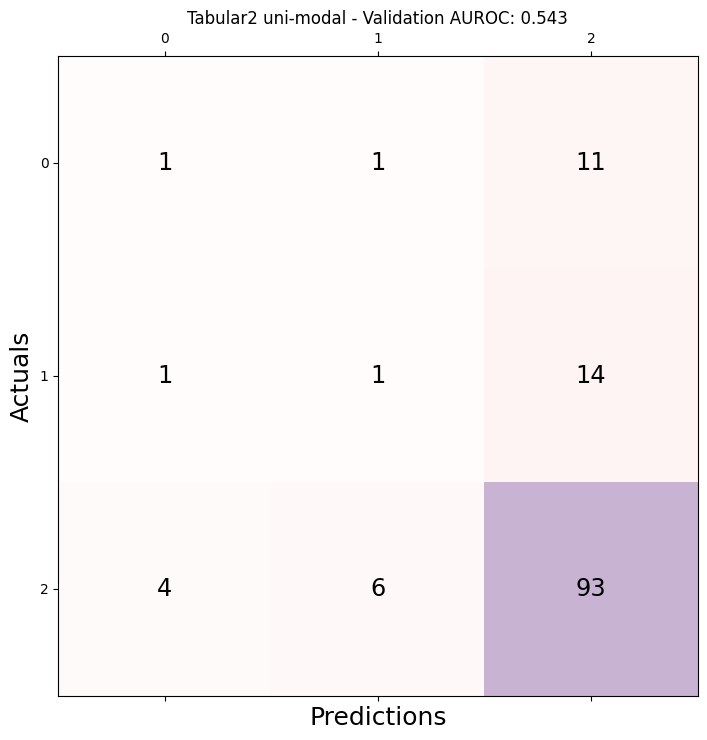

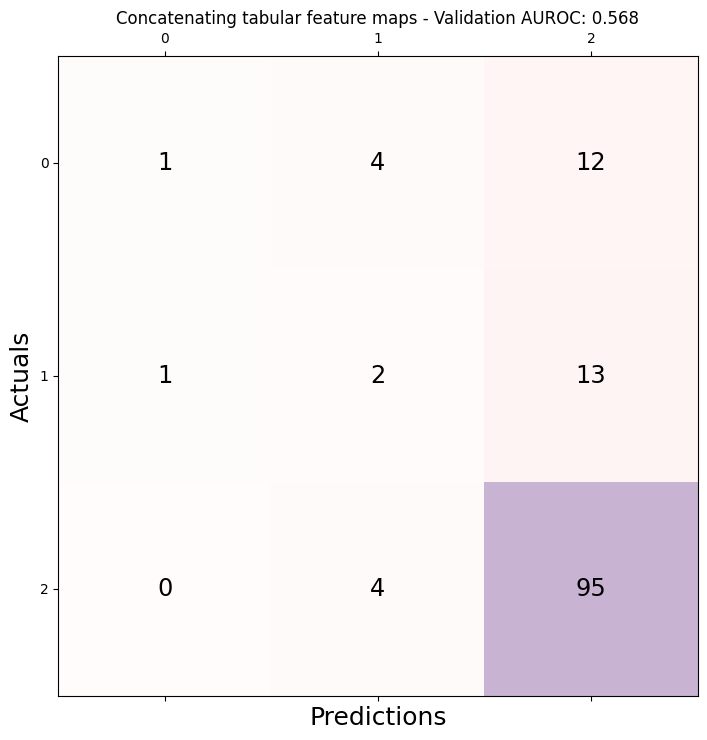

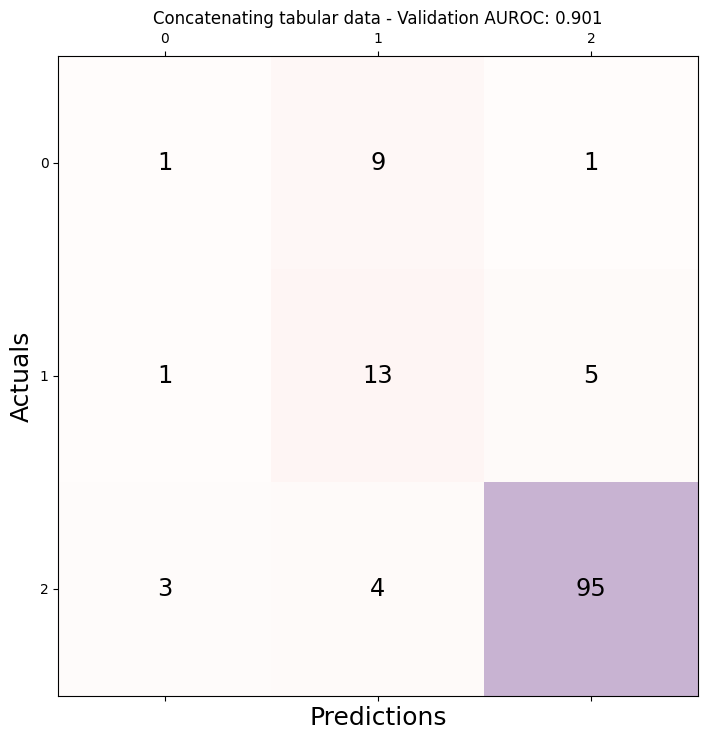

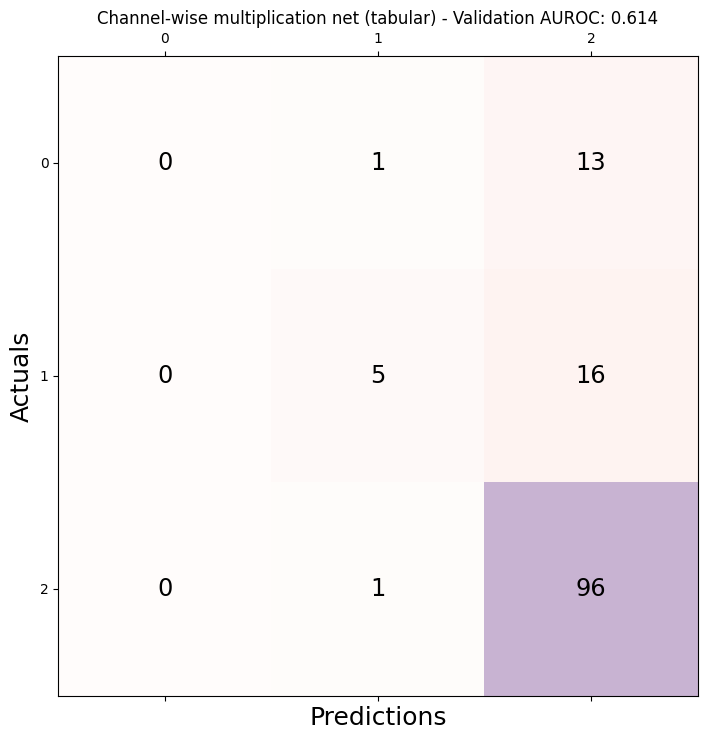

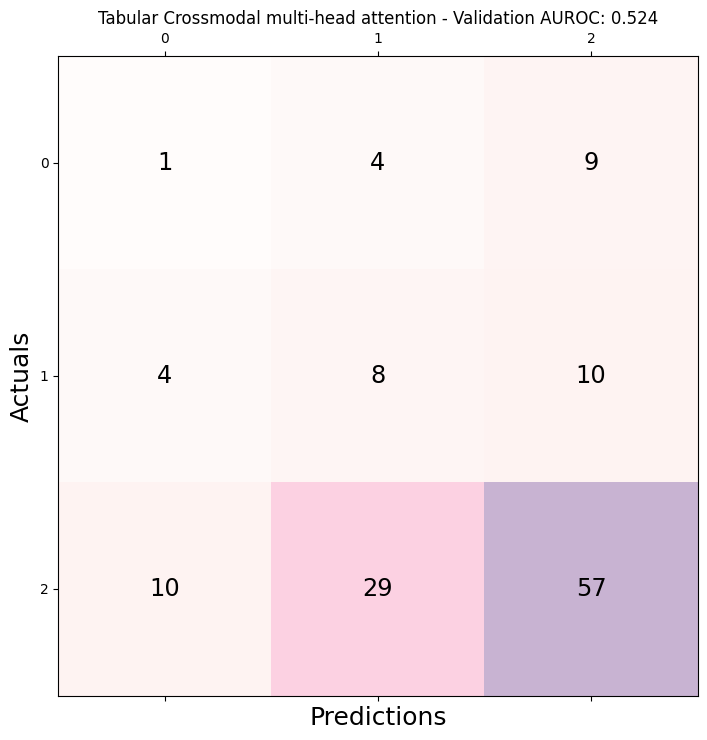

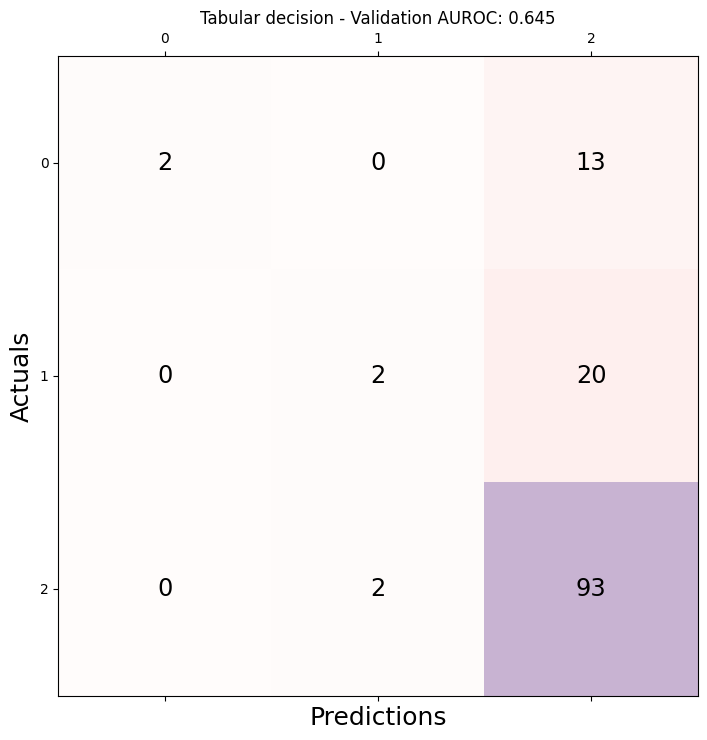

In [8]:
import fusilli
from fusilli.data import prepare_fusion_data
from fusilli.train import train_and_save_models
from fusilli.eval import ConfusionMatrix, ModelComparison
from fusilli.utils.model_chooser import import_chosen_fusion_models
import matplotlib.pyplot as plt

data_paths = {
    "tabular1": "tabular_1.csv",  # JOINT time-series (flattened)
    "tabular2": "tabular_2.csv",  # surveys + disability (flattened)
    "image": "",                  # нет картинок
}

output_paths = {
    "checkpoints": "path/to/checkpoints/dir",
    "losses": "path/to/losses/dir",
    "figures": "path/to/figures/dir",
}

model_conditions = {
    "modality_type": ["tabular1", "tabular2", "tabular_tabular"],
}

fusion_models = import_chosen_fusion_models(model_conditions)
trained_models = {}

for model in fusion_models:
    model_name = model.__name__

    data_module = prepare_fusion_data(
        prediction_task="multiclass",
        fusion_model=model,
        data_paths=data_paths,
        output_paths=output_paths,
    )
    n_classes = 3  # или посчитай по своим данным

    data_module.multiclass_dimensions = int(n_classes)

    trained_model = train_and_save_models(
        data_module=data_module,
        fusion_model=model,
    )

    fig_cm = ConfusionMatrix.from_final_val_data(trained_model)
    plt.savefig(f"{output_paths['figures']}/{model_name}_confusion_matrix.png")

    trained_models[model_name] = trained_model

comparison_fig = ModelComparison.from_final_val_data(trained_models)
plt.savefig(f"{output_paths['figures']}/model_comparison.png")

In [10]:
import pandas as pd

In [11]:
test_data_paths = {
    "tabular1": "tabular_1_test.csv",
    "tabular2": "tabular_2_test.csv",
    "image": "",
}

In [12]:
df = pd.read_csv("pirate_pain_test.csv")

# Таблица с лейблами, например: sample_index, label
labels = pd.read_csv("pirate_pain_test_labels.csv")
# fusilli хочет колонку 'prediction_label'
labels = labels.rename(columns={"label": "prediction_label"})

FileNotFoundError: [Errno 2] No such file or directory: 'pirate_pain_test_labels.csv'

In [ ]:
# Если n_legs хранится как строка "two"
df["disability"] = (df["n_legs"] != "two").astype(int)

# Если вдруг оно числовое, типа 2:
# df["disability"] = (df["n_legs"] != 2).astype(int)

pain_cols = ["pain_survey_1", "pain_survey_2", "pain_survey_3", "disability"]
# Если хочешь ещё pain_survey_4, просто добавь в список:
# pain_cols = ["pain_survey_1", "pain_survey_2", "pain_survey_3", "pain_survey_4", "disability"]

tab2_wide = (
    df.groupby("sample_index")
      .apply(flatten_over_time, feature_cols=pain_cols, T=T)
      .reset_index()
)

tab2 = tab2_wide.merge(labels, on="sample_index")
tab2 = tab2.rename(columns={"sample_index": "ID"})

# tab2: ID, pain_survey_1_1, pain_survey_2_1, ..., disability_T, prediction_label
tab2.to_csv("tabular_2.csv", index=False)

In [9]:
# Все колонки, которые начинаются с 'joint_'
exclude = (
    "joint_13", "joint_14", "joint_15", "joint_16",
    "joint_18", "joint_19", "joint_20", "joint_21",
    "joint_22", "joint_23", "joint_24", "joint_25", "joint_30"
)

joint_cols = [
    c for c in df.columns
    if c.startswith("joint_") and c not in exclude
]

tab1_wide = (
    df.groupby("sample_index")
      .apply(flatten_over_time, feature_cols=joint_cols, T=T)
      .reset_index()  # вернём sample_index как колонку
)

# Добавляем лейблы, переименовываем в формат fusilli
tab1 = tab1_wide.merge(labels, on="sample_index")
tab1 = tab1.rename(columns={"sample_index": "ID"})

# На этом шаге tab1: ID, joint_00_1, joint_01_1, ..., prediction_label
tab1.to_csv("tabular_1.csv", index=False)

In [ ]:
from fusilli.eval import Predictions

preds_df = Predictions.from_new_data(
    model_list=[trained_model],
    output_paths=output_paths,
    test_data_paths=test_data_paths,
    checkpoint_file_suffix=None,  # если нет суффикса
)

preds_df.to_csv(f"{output_paths['checkpoints']}/{model_name}_test_predictions.csv",
                index=False)
